# Defining urban census tracts
This script identifies tracts that are urbanized and within a core-based statistical area. It uses data including Census TIGER/Line boundaries for census tracts, urban areas, and core-based statistical areas, as well locale classifications from the National Center for Educational Statistics. 

This boundary layer should only be used with the historical version of the National Gentrification Intensity Map. That version longitudinally aggregates data into 2010 census tract boundaries. 

In [1]:
import geopandas
import ipumspy
import requests
import zipfile
import io
import os
import numpy
from ipumspy import IpumsApiClient, NhgisDataset, NhgisDatasetMetadata

### Identifying urban tracts on 2010 boundaries
This script draws on four boundary line data sources. 
- National Historic GIS 2010 census tract boundaries
- Census TIGER/Line files for 2020 Core-Based Statistical Areas (CBSAs)
- Census TIGER/Line files for 2020 Urban Areas 
- National Center for Education Statistics 2020 Locale Classifications

#### Tract boundaries
Start by pulling census tract boundaries from National Historical GIS. This requires a custom workflow based on the IPUMS API. To replicate, [create an NGHIS account](https://uma.pop.umn.edu/nhgis/user/new) and [register for an IPUMS API key](https://developer.ipums.org/docs/v2/get-started/). After querying the API and unpacking the nested file structure that it uses, load the boundaries as a geographic data frame with `geopandas`. 

In [2]:
# set IPUMS API key
ipums = IpumsApiClient("your key here")

In [3]:
# define the extract
extract = ipumspy.AggregateDataExtract(collection="nhgis",shapefiles=["us_tract_2010_tl2010"]) 

# submit API request
response = ipums.submit_extract(extract)
print(f"Submitted request 0{extract.extract_id}")

Submitted request 0282


In [4]:
# download the extract
ipums.download_extract(response)
print(f"Downloaded request 0{extract.extract_id}")

Downloaded request 0282


In [6]:
# first level of unzipping
outer_zip = f"nhgis0{extract.extract_id}_shape.zip"
outer_dir = outer_zip.replace(".zip", "")
with zipfile.ZipFile(outer_zip, "r") as z:
    z.extractall(outer_dir)
print(f"{outer_zip} extracted to {outer_dir}")

nhgis0282_shape.zip extracted to nhgis0282_shape


In [9]:
# load the spatial data
inner_zip = f"{outer_dir}/{outer_dir}/nhgis0{extract.extract_id}_shapefile_tl2010_us_tract_2010.zip"
tracts = geopandas.read_file(f"zip://{inner_zip}!/US_tract_2010.shp")
tracts = tracts.to_crs("ESRI:102003")
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 73669 entries, 0 to 73668
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   73669 non-null  object  
 1   COUNTYFP10  73669 non-null  object  
 2   TRACTCE10   73669 non-null  object  
 3   GEOID10     73669 non-null  object  
 4   NAME10      73669 non-null  object  
 5   NAMELSAD10  73669 non-null  object  
 6   MTFCC10     73669 non-null  object  
 7   FUNCSTAT10  73669 non-null  object  
 8   ALAND10     73669 non-null  int64   
 9   AWATER10    73669 non-null  int64   
 10  INTPTLAT10  73669 non-null  object  
 11  INTPTLON10  73669 non-null  object  
 12  GISJOIN     73669 non-null  object  
 13  Shape_area  73669 non-null  float64 
 14  Shape_len   73669 non-null  float64 
 15  geometry    73669 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(11)
memory usage: 9.0+ MB


#### Other geographies
The other spatial data layers are publicaly available via URLs. These can be downloaded directly, and then loaded as geographic data frames using `geopandas`.

<Axes: >

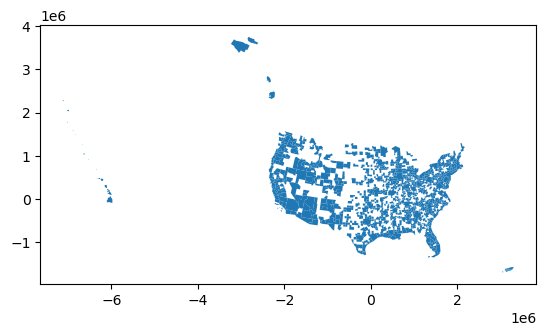

In [10]:
# load core-based statistical areas
## download the data
url = "https://www2.census.gov/geo/tiger/TIGER2020/CBSA/tl_2020_us_cbsa.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip:
    zip.extractall("cbsa_boundaries")

# read into a spatial data frame
cbsas = geopandas.read_file("cbsa_boundaries/tl_2020_us_cbsa.shp")
cbsas = cbsas.to_crs("ESRI:102003")
cbsas.plot()

#### Other geographies
The other source layers are available via URLS. These can be downloaded directly and then loaded as geographic data frames using `geopandas`. 

<Axes: >

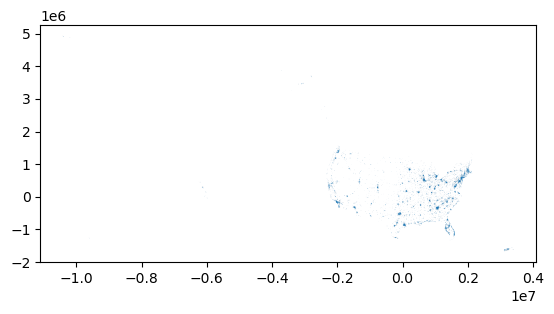

In [11]:
# load urban areas
## download the data
url = "https://www2.census.gov/geo/tiger/TIGER2020/UAC/tl_2020_us_uac20.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip:
    zip.extractall("urbanarea_boundaries")

# read into a spatial data frame
urban_areas = geopandas.read_file("urbanarea_boundaries/tl_2020_us_uac20.shp")
urban_areas = urban_areas.to_crs("ESRI:102003")
urban_areas.plot()

In [12]:
# load locale data -- Warning: It's a big file. This will take some time. 
## download the data
url = "https://nces.ed.gov/programs/edge/data/edge_locale20_nces_all_us.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip:
    zip.extractall("locale_boundaries")

# read into a spatial data frame
locales = geopandas.read_file("locale_boundaries/edge_locale20_nces_all_us.shp")
locales = locales.to_crs("ESRI:102003")
locales.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LOCALE    564 non-null    object  
 1   STATEFP   564 non-null    object  
 2   GEO_YEAR  564 non-null    object  
 3   geometry  564 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 17.8+ KB


# Geoprocessing
The workflow then identifies urban census tracts within CBSAs. After that, it curates a relevant list of geographic identifiers for the tracts using spatial joins. 

In [6]:
# create centroids for each tract
## create centroid
tract_centroids = tracts.copy()
tract_centroids["geometry"] = tracts.centroid

## select tract variables
variables = ["GISJOIN", "GEOID10", "STATEFP10", "COUNTYFP10", "TRACTCE10"]
tract_centroids = tract_centroids[variables + ["geometry"]]

## drop tracts in Puerto Rico
tract_centroids = tract_centroids[~tract_centroids["GEOID10"].str.startswith("72")]

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 72765 entries, 0 to 73668
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GISJOIN     72765 non-null  object  
 1   GEOID10     72765 non-null  object  
 2   STATEFP10   72765 non-null  object  
 3   COUNTYFP10  72765 non-null  object  
 4   TRACTCE10   72765 non-null  object  
 5   geometry    72765 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 3.9+ MB


In [7]:
# find centroids within CBSAs
tract_centroids = geopandas.clip(tract_centroids, cbsas)
tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 67474 entries, 20058 to 72850
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GISJOIN     67474 non-null  object  
 1   GEOID10     67474 non-null  object  
 2   STATEFP10   67474 non-null  object  
 3   COUNTYFP10  67474 non-null  object  
 4   TRACTCE10   67474 non-null  object  
 5   geometry    67474 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 3.6+ MB


In [8]:
# and within urban areas
tract_centroids = geopandas.clip(tract_centroids, urban_areas)
tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49646 entries, 19910 to 72850
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GISJOIN     49646 non-null  object  
 1   GEOID10     49646 non-null  object  
 2   STATEFP10   49646 non-null  object  
 3   COUNTYFP10  49646 non-null  object  
 4   TRACTCE10   49646 non-null  object  
 5   geometry    49646 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 2.7+ MB


Now do some spatial joining to gather geography variables for each tract. 

In [9]:
# add CBSA indicators to the tracts
variables = ["CBSAFP", "NAME", "NAMELSAD"]
cbsas = cbsas[variables + ["geometry"]]
cbsas = cbsas.rename(columns = {
    "CBSAFP": "CBSAFP",
    "NAME": "CBSA_NAME",
    "NAMELSAD": "CBSA_NAMELSAD"
})

# spatial join tracts to CBSAs
tract_centroids = geopandas.sjoin(
    left_df = tract_centroids,
    right_df = cbsas,
    how = "left",
    predicate = "within"
).drop(columns=["index_right"])

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49646 entries, 19910 to 72850
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        49646 non-null  object  
 1   GEOID10        49646 non-null  object  
 2   STATEFP10      49646 non-null  object  
 3   COUNTYFP10     49646 non-null  object  
 4   TRACTCE10      49646 non-null  object  
 5   geometry       49646 non-null  geometry
 6   CBSAFP         49646 non-null  object  
 7   CBSA_NAME      49646 non-null  object  
 8   CBSA_NAMELSAD  49646 non-null  object  
dtypes: geometry(1), object(8)
memory usage: 3.8+ MB


In [10]:
# add urban indicators to the tracts
variables = ["UACE20", "NAME20", "NAMELSAD20"]
urban_areas = urban_areas[variables + ["geometry"]]
urban_areas = urban_areas.rename(columns = {
    "UACE20": "UAFP",
    "NAME20": "UA_NAME",
    "NAMELSAD20": "UA_NAMELSAD"
})

# spatial join tracts to urban areas
tract_centroids = geopandas.sjoin(
    left_df = tract_centroids,
    right_df = urban_areas,
    how = "left",
    predicate = "within"
).drop(columns=["index_right"])

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49646 entries, 19910 to 72850
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        49646 non-null  object  
 1   GEOID10        49646 non-null  object  
 2   STATEFP10      49646 non-null  object  
 3   COUNTYFP10     49646 non-null  object  
 4   TRACTCE10      49646 non-null  object  
 5   geometry       49646 non-null  geometry
 6   CBSAFP         49646 non-null  object  
 7   CBSA_NAME      49646 non-null  object  
 8   CBSA_NAMELSAD  49646 non-null  object  
 9   UAFP           49646 non-null  object  
 10  UA_NAME        49646 non-null  object  
 11  UA_NAMELSAD    49646 non-null  object  
dtypes: geometry(1), object(11)
memory usage: 4.9+ MB


In [11]:
# add locale type to the tracts
variables = ["LOCALE"]
locales = locales[variables + ["geometry"]]

# spatial join tracts to urban areas
tract_centroids = geopandas.sjoin_nearest(
    left_df = tract_centroids,
    right_df = locales,
    how = "left"
).drop(columns=["index_right"])

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49646 entries, 19910 to 72850
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        49646 non-null  object  
 1   GEOID10        49646 non-null  object  
 2   STATEFP10      49646 non-null  object  
 3   COUNTYFP10     49646 non-null  object  
 4   TRACTCE10      49646 non-null  object  
 5   geometry       49646 non-null  geometry
 6   CBSAFP         49646 non-null  object  
 7   CBSA_NAME      49646 non-null  object  
 8   CBSA_NAMELSAD  49646 non-null  object  
 9   UAFP           49646 non-null  object  
 10  UA_NAME        49646 non-null  object  
 11  UA_NAMELSAD    49646 non-null  object  
 12  LOCALE         49646 non-null  object  
dtypes: geometry(1), object(12)
memory usage: 5.3+ MB


In [12]:
# add a descriptive label for locale type
# Define the conditions 
conditions = [
    tract_centroids["LOCALE"].isin(["11", "12", "13"]),
    tract_centroids["LOCALE"].isin(["21", "22", "23"]),
    tract_centroids["LOCALE"].isin(["32", "33", "42", "43"]),
    tract_centroids["LOCALE"].isin(["31", "41"])
]

# list the corresponding outputs
choices = ["City", "Suburb", "Exurb", "Rural"]

# create the new column
tract_centroids["LocaleType"] = numpy.select(conditions, choices, default=None)

print(tract_centroids["LocaleType"].value_counts())

LocaleType
City      23918
Suburb    22091
Exurb      1892
Rural      1745
Name: count, dtype: int64


# Finishing up
Finally, we'll join the centroid layer back to the original tract polygons. After that, we'll save the boundaries to a `.gpkg` spatial database. 

In [13]:
# drop duplicate columns
variables = ['GISJOIN', 'geometry']
polygons = tracts[variables]
points = tract_centroids.drop('geometry', axis=1)

# merge centroid data back to polygons
tracts_final = polygons.merge(points, on='GISJOIN', how='right')
tracts_final

,GISJOIN,geometry,GEOID10,STATEFP10,COUNTYFP10,TRACTCE10,CBSAFP,CBSA_NAME,CBSA_NAMELSAD,UAFP,UA_NAME,UA_NAMELSAD,LOCALE,LocaleType
0,G4800610014400,"POLYGON ((-149625.543 -1276306.434, -148026.71...",48061014400,48,061,014400,15180,"Brownsville-Harlingen, TX","Brownsville-Harlingen, TX Metro Area",10972,"Brownsville, TX","Brownsville, TX Urban Area",12,City
1,G4800610012506,"POLYGON ((-159460.991 -1268840.607, -159450.74...",48061012506,48,061,012506,15180,"Brownsville-Harlingen, TX","Brownsville-Harlingen, TX Metro Area",10972,"Brownsville, TX","Brownsville, TX Urban Area",22,Suburb
2,G4800610012402,"POLYGON ((-147307.446 -1268494.394, -147278.48...",48061012402,48,061,012402,15180,"Brownsville-Harlingen, TX","Brownsville-Harlingen, TX Metro Area",10972,"Brownsville, TX","Brownsville, TX Urban Area",22,Suburb
3,G4802150022702,"POLYGON ((-197494.478 -1261492.797, -197494.61...",48215022702,48,215,022702,32580,"McAllen-Edinburg-Mission, TX","McAllen-Edinburg-Mission, TX Metro Area",52390,"McAllen, TX","McAllen, TX Urban Area",21,Suburb
4,G4800610011600,"POLYGON ((-162218.996 -1265548.596, -162232.67...",48061011600,48,061,011600,15180,"Brownsville-Harlingen, TX","Brownsville-Harlingen, TX Metro Area",36892,"Harlingen, TX","Harlingen, TX Urban Area",22,Suburb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49641,G0200900000500,"POLYGON ((-2798986.752 3699840.075, -2798936.8...",02090000500,02,090,000500,21820,"Fairbanks, AK","Fairbanks, AK Metro Area",28549,"Fairbanks, AK","Fairbanks, AK Urban Area",13,City
49642,G0200900000700,"POLYGON ((-2803096.29 3700255.74, -2803094.483...",02090000700,02,090,000700,21820,"Fairbanks, AK","Fairbanks, AK Metro Area",28549,"Fairbanks, AK","Fairbanks, AK Urban Area",13,City
49643,G0200900000600,"POLYGON ((-2798986.752 3699840.075, -2798993.1...",02090000600,02,090,000600,21820,"Fairbanks, AK","Fairbanks, AK Metro Area",28549,"Fairbanks, AK","Fairbanks, AK Urban Area",13,City
49644,G0200900000800,"POLYGON ((-2805482.574 3702469.097, -2805480.1...",02090000800,02,090,000800,21820,"Fairbanks, AK","Fairbanks, AK Metro Area",28549,"Fairbanks, AK","Fairbanks, AK Urban Area",23,Suburb


In [15]:
# save to geopackage
tracts_final.to_file(
    filename = "tract_boundaries.gpkg",
    layer = "metrotracts_2010tr",
    driver = "GPKG"
)
print("Saved to geopackage")

Saved to geopackage


In [16]:
# save a CSV version
tracts_final.drop('geometry', axis=1).to_csv('metrotracts_2010tr.csv', index=False)
print("Saved csv version")

Saved csv version


In [ ]:
# and save CSV with WKT geometries
tracts_final.to_csv('boundaries_metrotracts_2010tr.csv', index=False)
print("Saved WKT geometries")